# S&P 500 Performance Analysis and Price Prediction

## Part 1: Setup and Data Collection

### Objective
In this part, we will:
1. Download historical S&P 500 data from Yahoo Finance.
2. Download Federal Funds Effective Rate (FEDFUNDS) data for the same period.


### Step 1: Download S&P 500 Historical Data
We will fetch the historical data for the S&P 500 index from December 1, 2004, to December 1, 2024.


In [47]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for S&P 500
ticker_symbol = '^GSPC'

# Define the date range
start_date = '2004-12-01'
end_date = '2024-12-01'

# Download the data
sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save the raw dataset to a CSV file
raw_file_path = 'SP500_raw_data.csv'
sp500_data.to_csv(raw_file_path)

# Display the first few rows of the raw dataset
print("Raw S&P 500 Data saved to file:")
print(sp500_data.head())


[*********************100%***********************]  1 of 1 completed

Raw S&P 500 Data saved to file:
Price                        Adj Close        Close         High          Low  \
Ticker                           ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                            
2004-12-01 00:00:00+00:00  1191.369995  1191.369995  1191.369995  1173.780029   
2004-12-02 00:00:00+00:00  1190.329956  1190.329956  1194.800049  1186.719971   
2004-12-03 00:00:00+00:00  1191.170044  1191.170044  1197.459961  1187.709961   
2004-12-06 00:00:00+00:00  1190.250000  1190.250000  1192.410034  1185.180054   
2004-12-07 00:00:00+00:00  1177.069946  1177.069946  1192.170044  1177.069946   

Price                             Open      Volume  
Ticker                           ^GSPC       ^GSPC  
Date                                                
2004-12-01 00:00:00+00:00  1173.780029  1772800000  
2004-12-02 00:00:00+00:00  1191.369995  1774900000  
2004-12-03 00:00:00+00:00  1190.329956  1566700000  
2

### Step 2: Download Federal Funds Effective Rate (FEDFUNDS) Data
We will use the FRED API to fetch FEDFUNDS data for the same date range.


In [48]:
# Correct import
from pandas_datareader import data as pdr

# Download FEDFUNDS data
fedfunds_data = pdr.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)

# Display the first few rows of the raw FEDFUNDS dataset
print("Raw FEDFUNDS Data:")
print(fedfunds_data.head())


Raw FEDFUNDS Data:
            FEDFUNDS
DATE                
2004-12-01      2.16
2005-01-01      2.28
2005-02-01      2.50
2005-03-01      2.63
2005-04-01      2.79


## Part 2: Data Preprocessing

### Step 1: Fix the Format of S&P 500 Historical Data
The current dataset has:
1. Irrelevant rows (e.g., "Ticker").
2. Incorrect column headers.
3. Date values used as an index, making it harder to process later.

We will fix these issues by:
- Dropping the first row with irrelevant data.
- Resetting the index to include the "Date" column as part of the dataset.
- Renaming the columns for clarity.


In [49]:
# Step 1: Skip the first two rows
sp500_data_cleaned = pd.read_csv("SP500_raw_data.csv", skiprows=2)

# Step 2: Rename columns for clarity
sp500_data_cleaned.columns = [
    "Date", "SP500_Adj_Close", "SP500_Close",
    "SP500_High", "SP500_Low", "SP500_Open", "SP500_Volume"
]

# Step 3: Convert the "Date" column to datetime format
sp500_data_cleaned['Date'] = pd.to_datetime(sp500_data_cleaned['Date'], errors='coerce')

# Display the cleaned dataset
sp500_data_cleaned.head()


,Date,SP500_Adj_Close,SP500_Close,SP500_High,SP500_Low,SP500_Open,SP500_Volume
0,2004-12-01 00:00:00+00:00,1191.369995,1191.369995,1191.369995,1173.780029,1173.780029,1772800000
1,2004-12-02 00:00:00+00:00,1190.329956,1190.329956,1194.800049,1186.719971,1191.369995,1774900000
2,2004-12-03 00:00:00+00:00,1191.170044,1191.170044,1197.459961,1187.709961,1190.329956,1566700000
3,2004-12-06 00:00:00+00:00,1190.250000,1190.250000,1192.410034,1185.180054,1191.170044,1354400000
4,2004-12-07 00:00:00+00:00,1177.069946,1177.069946,1192.170044,1177.069946,1190.250000,1533900000


### Step 2: Interpolate FEDFUNDS Data to Make It Daily
The Federal Funds Effective Rate (FEDFUNDS) dataset is available on a monthly basis. To match the daily granularity of the S&P 500 data, we will:
1. Resample the data to daily frequency.
2. Interpolate missing values to fill gaps smoothly.
3. Ensure the `Date` column aligns with the daily frequency.

In [50]:
# Assuming FEDFUNDS data is already loaded into a variable named 'fedfunds_data'
from pandas_datareader import data as pdr

# Define the date range for FEDFUNDS data
start_date = '2004-12-01'
end_date = '2024-12-01'

# Fetch the FEDFUNDS data
fedfunds_data = pdr.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)

# Reset the index to prepare for interpolation
fedfunds_data.reset_index(inplace=True)

# Convert the "DATE" column to datetime (if not already)
fedfunds_data['DATE'] = pd.to_datetime(fedfunds_data['DATE'])

# Rename columns for consistency
fedfunds_data.rename(columns={'DATE': 'Date', 'FEDFUNDS': 'Effective_Rate'}, inplace=True)

# Set the Date as the index for resampling
fedfunds_data.set_index('Date', inplace=True)

# Resample to daily frequency and interpolate missing values
fedfunds_daily = fedfunds_data.resample('D').interpolate(method='linear')

# Reset the index to bring back the Date column
fedfunds_daily.reset_index(inplace=True)

# Display the interpolated dataset
print("Interpolated FEDFUNDS Data:")
print(fedfunds_daily.head())


Interpolated FEDFUNDS Data:
        Date  Effective_Rate
0 2004-12-01        2.160000
1 2004-12-02        2.163871
2 2004-12-03        2.167742
3 2004-12-04        2.171613
4 2004-12-05        2.175484


### Step 3: Combine Both Datasets
We now have two preprocessed datasets:
1. **S&P 500 Data**: Cleaned and formatted with daily values.
2. **FEDFUNDS Data**: Interpolated to daily frequency.

The goal is to:
1. Merge both datasets on the `Date` column.
2. Ensure all dates from December 1, 2004, to December 1, 2024, are included.
3. Fill any missing values using forward-fill and backward-fill techniques.


In [51]:
# Step 1: Standardize the Date columns' timezone to remove any inconsistencies
sp500_data_cleaned['Date'] = sp500_data_cleaned['Date'].dt.tz_localize(None)
fedfunds_daily['Date'] = fedfunds_daily['Date'].dt.tz_localize(None)

# Step 2: Create a complete date range
complete_date_range = pd.date_range(start='2004-12-01', end='2024-12-01', freq='D')
complete_data = pd.DataFrame({'Date': complete_date_range})

# Step 3: Merge the S&P 500 data with the complete date range
merged_data = pd.merge(complete_data, sp500_data_cleaned, on='Date', how='left')

# Step 4: Merge the FEDFUNDS data
merged_data = pd.merge(merged_data, fedfunds_daily, on='Date', how='left')

# Step 5: Fill missing values using forward-fill and backward-fill
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)

# Display the final combined dataset
print("Combined Dataset:")
print(merged_data.head())


Combined Dataset:
        Date  SP500_Adj_Close  SP500_Close   SP500_High    SP500_Low  \
0 2004-12-01      1191.369995  1191.369995  1191.369995  1173.780029   
1 2004-12-02      1190.329956  1190.329956  1194.800049  1186.719971   
2 2004-12-03      1191.170044  1191.170044  1197.459961  1187.709961   
3 2004-12-04      1191.170044  1191.170044  1197.459961  1187.709961   
4 2004-12-05      1191.170044  1191.170044  1197.459961  1187.709961   

    SP500_Open  SP500_Volume  Effective_Rate  
0  1173.780029  1.772800e+09        2.160000  
1  1191.369995  1.774900e+09        2.163871  
2  1190.329956  1.566700e+09        2.167742  
3  1190.329956  1.566700e+09        2.171613  
4  1190.329956  1.566700e+09        2.175484  


<ipython-input-51-8c6bc535962c>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)
<ipython-input-51-8c6bc535962c>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='bfill', inplace=True)


### Step 4: Data Cleaning

#### Objective:
1. **Data Cleaning**: Handle missing or erroneous values and normalize the dataset.
2. **Boxplot Visualization**: Visualize each column to detect outliers.
3. **Outlier Detection and Removal**: Remove rows with significant outliers.


Missing Values:
Date               0
SP500_Adj_Close    0
SP500_Close        0
SP500_High         0
SP500_Low          0
SP500_Open         0
SP500_Volume       0
Effective_Rate     0
dtype: int64


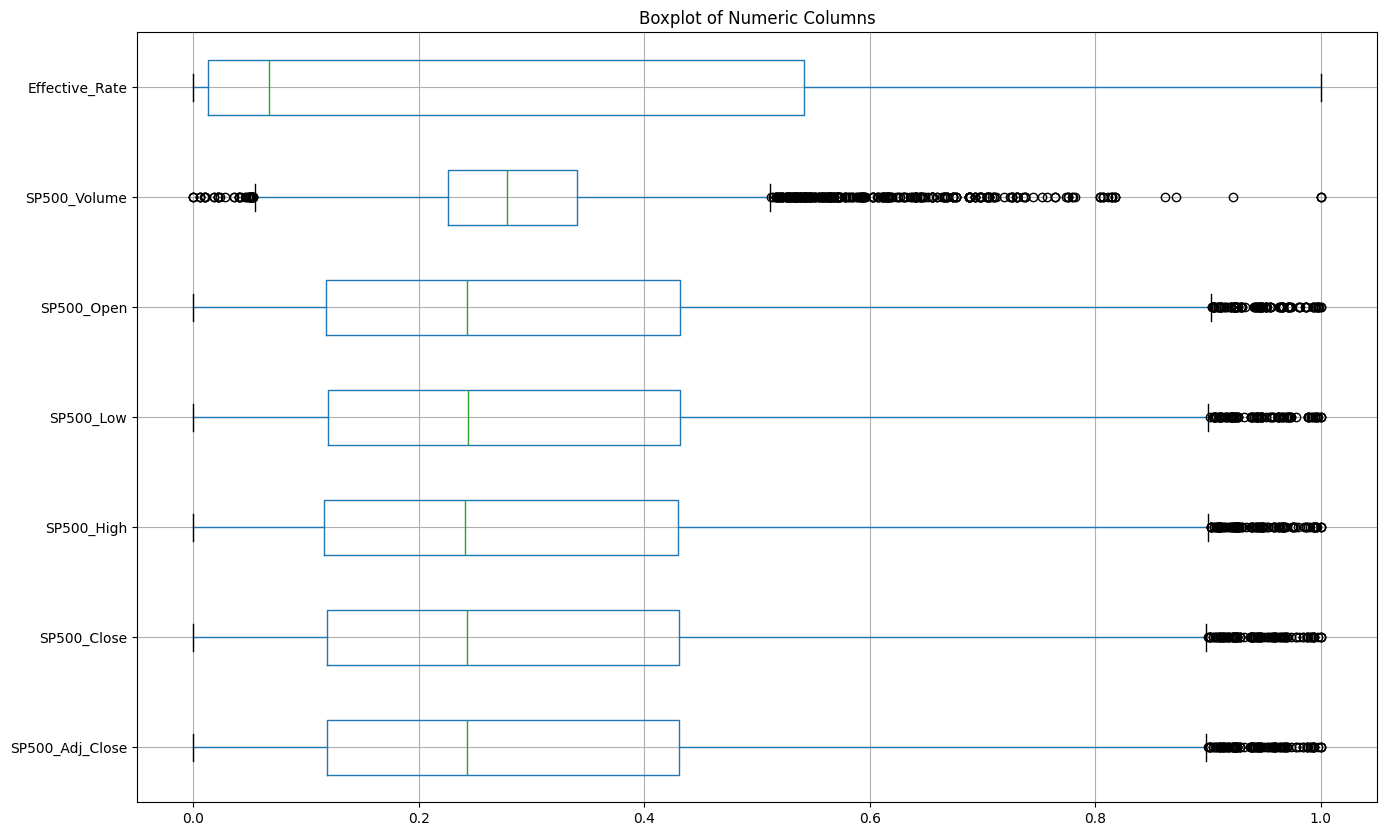

Cleaned Dataset:
        Date  SP500_Adj_Close  SP500_Close  SP500_High  SP500_Low  SP500_Open  \
0 2004-12-01         0.096127     0.096127    0.092748   0.094992    0.092693   
1 2004-12-02         0.095932     0.095932    0.093389   0.097416    0.095990   
2 2004-12-03         0.096089     0.096089    0.093887   0.097602    0.095795   
3 2004-12-04         0.096089     0.096089    0.093887   0.097602    0.095795   
4 2004-12-05         0.096089     0.096089    0.093887   0.097602    0.095795   

   SP500_Volume  Effective_Rate  
0      0.097645        0.399621  
1      0.097841        0.400354  
2      0.078440        0.401087  
3      0.078440        0.401821  
4      0.078440        0.402554  


In [52]:
import matplotlib.pyplot as plt

# Step 1: Identify and Handle Missing Values
# Check for missing values in the dataset
print("Missing Values:")
print(merged_data.isnull().sum())

# Optionally, fill missing values (e.g., with median values if needed)
merged_data.fillna(merged_data.median(), inplace=True)

# Step 2: Normalize Numeric Columns
# Identify numeric columns
numeric_columns = [
    "SP500_Adj_Close", "SP500_Close", "SP500_High",
    "SP500_Low", "SP500_Open", "SP500_Volume", "Effective_Rate"
]

# Normalize using Min-Max scaling
merged_data[numeric_columns] = (
    merged_data[numeric_columns] - merged_data[numeric_columns].min()) / (
    merged_data[numeric_columns].max() - merged_data[numeric_columns].min())

# Step 3: Boxplot Visualization for Outlier Detection
plt.figure(figsize=(16, 10))
merged_data.boxplot(column=numeric_columns, vert=False)
plt.title("Boxplot of Numeric Columns")
plt.show()

# Step 4: Outlier Detection and Removal
# Define a function to remove outliers (using IQR method)
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from numeric columns
merged_data_cleaned = remove_outliers(merged_data, numeric_columns)

# Display the cleaned dataset
print("Cleaned Dataset:")
print(merged_data_cleaned.head())


In [53]:
# Save the cleaned dataset to a CSV file
output_file_path = 'SP500_preprocessed_data.csv'
merged_data_cleaned.to_csv(output_file_path, index=False)

print(f"Cleaned dataset has been saved to {output_file_path}.")


Cleaned dataset has been saved to SP500_preprocessed_data.csv.


# Part 3: Predicting S&P 500 Price Evolution

## Objective:
Train multiple models to predict the **next day’s S&P 500 closing price** and evaluate their performance. Then, use the best-performing model for longer horizon predictions (1 month, 3 months, 6 months, and 1 year).

---

## Section 1: Traditional ML Models

### Models:
1. **Linear Regression**:
   - A simple model that assumes a linear relationship between input features and the target variable.
   - Best suited for data with linear trends.

2. **Random Forest Regressor**:
   - An ensemble learning method that uses multiple decision trees for predictions.
   - Handles non-linear relationships and works well on complex datasets.

3. **Support Vector Regressor (SVR)**:
   - A kernel-based regression technique that finds a hyperplane to minimize prediction error.
   - Effective for small datasets and works in high-dimensional spaces.

---

### Step 1: Prepare Data for ML Models
We need to:
1. **Create Lagged Features**:
   - Generate a column for the next day’s target price using `.shift(-1)`.
2. **Split Data**:
   - Separate the dataset into features (`X`) and target (`y`).
   - Use an 80-20 split for training and testing.


In [54]:
from sklearn.model_selection import train_test_split

# Create lagged features for ML models
merged_data_cleaned['SP500_Target'] = merged_data_cleaned['SP500_Close'].shift(-1)

# Drop the last row with NaN in the target
merged_data_cleaned.dropna(inplace=True)

# Features for ML models
X_ml = merged_data_cleaned[["SP500_Close", "SP500_Adj_Close", "SP500_High", "SP500_Low", "SP500_Open", "Effective_Rate"]]
y_ml = merged_data_cleaned["SP500_Target"]

# Split data for ML models
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

### ML Models:
1. **Linear Regression**: Assumes a linear relationship between features and the target.
2. **Random Forest**: Captures non-linear relationships and reduces overfitting through averaging.
3. **SVR**: Effective for smaller datasets and high-dimensional spaces.

#### Metrics:
- **MSE (Mean Squared Error)**: Measures the average squared difference between predicted and actual values. Lower is better.
- **MAE (Mean Average Error)**: Measures the average difference between predicted and actual values. Lower is better.


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize ML models
ml_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR()
}

# Train and evaluate ML models
ml_results = {}
for model_name, model in ml_models.items():
    model.fit(X_train_ml, y_train_ml)
    predictions = model.predict(X_test_ml)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_ml, predictions)
    mae = mean_absolute_error(y_test_ml, predictions)

    # Store the metrics
    ml_results[model_name] = {
        "MSE": mse,
        "MAE": mae
    }

    # Print the metrics for each model
    print(f"{model_name} Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print()

# Optionally, display results in a tabular format
import pandas as pd
metrics_df = pd.DataFrame(ml_results).T  # Transpose to align models as rows
print("Model Evaluation Metrics:")
print(metrics_df)


Linear Regression Metrics:
  MSE: 0.0000
  MAE: 0.0021

Random Forest Metrics:
  MSE: 0.0000
  MAE: 0.0025

Support Vector Regressor Metrics:
  MSE: 0.0025
  MAE: 0.0441

Model Evaluation Metrics:
                               MSE       MAE
Linear Regression         0.000020  0.002125
Random Forest             0.000024  0.002522
Support Vector Regressor  0.002470  0.044070


### Why VAR is Special:
1. **Multivariate Time Series**:
   - Unlike traditional ML models, which predict a single target, VAR predicts the evolution of all variables simultaneously.
   - Uses lagged values of all variables to capture interactions.

2. **Captures Interdependencies**:
   - Ideal for datasets where variables (e.g., `SP500_Close` and `Effective_Rate`) influence each other.

3. **Use Case**:
   - Excellent for financial markets, where macroeconomic factors impact stock prices.


In [56]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare data for VAR
var_data = merged_data_cleaned[["SP500_Close", "SP500_Adj_Close", "SP500_High", "SP500_Low", "SP500_Open", "Effective_Rate"]]

# Split VAR data into training and testing sets
train_size = int(len(var_data) * 0.8)
var_train, var_test = var_data.iloc[:train_size], var_data.iloc[train_size:]

# Train the VAR model
var_model = VAR(var_train)
var_results = var_model.fit(maxlags=15)

# Forecast for the testing period
forecast_steps = len(var_test)
var_forecast = var_results.forecast(var_train.values[-var_results.k_ar:], steps=forecast_steps)

# Convert forecast to DataFrame with appropriate columns
var_forecast_df = pd.DataFrame(var_forecast, columns=var_train.columns, index=var_test.index)

# Evaluate VAR predictions
var_mse = mean_squared_error(var_test["SP500_Close"], var_forecast_df["SP500_Close"])
var_mae = mean_absolute_error(var_test["SP500_Close"], var_forecast_df["SP500_Close"])

# Print metrics
print(f"VAR Model Metrics:")
print(f"  MSE: {var_mse:.4f}")
print(f"  MAE: {var_mae:.4f}")
print()

# Add VAR results to the summary
ml_results['VAR Model'] = {
    "MSE": var_mse,
    "MAE": var_mae
}

# Optionally, display results in a tabular format
metrics_df = pd.DataFrame(ml_results).T  # Transpose to align models as rows
print("Model Evaluation Metrics:")
print(metrics_df)


VAR Model Metrics:
  MSE: 0.0261
  MAE: 0.1465

Model Evaluation Metrics:
                               MSE       MAE
Linear Regression         0.000020  0.002125
Random Forest             0.000024  0.002522
Support Vector Regressor  0.002470  0.044070
VAR Model                 0.026052  0.146466


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


#### Compare the Models:
1. List the MSE and MAE for each model.
2. Identify the best-performing model for further predictions (1 month, 3 months, etc.).


In [57]:
from tabulate import tabulate

# Convert the results dictionary into a pandas DataFrame
metrics_df = pd.DataFrame(ml_results).T  # Transpose to align models as rows
metrics_df.reset_index(inplace=True)  # Make model names a column
metrics_df.columns = ["Model", "MSE", "MAE"]  # Rename columns for clarity

# Display the table using tabulate
print("\nModel Performance Summary:")
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))




Model Performance Summary:
+----+--------------------------+-------------+------------+
|    | Model                    |         MSE |        MAE |
+====+==========================+=============+============+
|  0 | Linear Regression        | 1.97404e-05 | 0.00212518 |
+----+--------------------------+-------------+------------+
|  1 | Random Forest            | 2.39357e-05 | 0.00252155 |
+----+--------------------------+-------------+------------+
|  2 | Support Vector Regressor | 0.00247043  | 0.0440702  |
+----+--------------------------+-------------+------------+
|  3 | VAR Model                | 0.0260522   | 0.146466   |
+----+--------------------------+-------------+------------+


## Why Did Linear Regression Perform Better?

### Observations:
1. **Linear Relationships**:
   - The dataset might exhibit a predominantly linear relationship between the features (e.g., `SP500_Close`, `Effective_Rate`) and the target variable (`SP500_Target`).
   - Linear Regression excels in such cases, leading to lower Mean Squared Error (MSE) compared to more complex models.

2. **Simplicity of the Task**:
   - For next-day predictions, the impact of features might be straightforward and linearly dependent.
   - Complex models like Random Forest or SVR may struggle to provide significant gains for this simple task, particularly if the dataset size is small.

3. **Low Variability**:
   - If the stock prices and related features exhibit low variability, Linear Regression can effectively capture the trend without overfitting.

4. **Out-of-the-Box Performance**:
   - Linear Regression requires no hyperparameter tuning, whereas Random Forest and SVR perform best with optimized hyperparameters.
   - The lack of tuning might have caused other models to underperform relative to Linear Regression.

---

## Why Should We Still Consider VAR for Longer-Term Predictions?

### Multivariate Time Series Analysis:
- Unlike Linear Regression, VAR leverages lagged values of all variables in the dataset (e.g., `SP500_Close`, `Effective_Rate`, etc.).
- It captures interdependencies and feedback loops between variables, which are especially crucial for longer-term predictions.

### Non-Linearity in Long Horizons:
- Over longer horizons (e.g., 1 month, 3 months, etc.), non-linear relationships and time-dependent interactions between variables become more prominent.
- Linear Regression, which assumes linearity, may fail to generalize for such complex scenarios.

### Data-Driven Insights:
- VAR can reveal hidden patterns and causal relationships between macroeconomic indicators and stock prices, improving the quality of predictions for longer time frames.

---

## Conclusion:
- **Next-Day Predictions**: Linear Regression performs well due to the simplicity and linearity of the task.
- **Long-Term Predictions**: VAR is likely to outperform Linear Regression for 1 month, 3 months, or longer horizons due to its ability to capture multivariate dynamics and temporal dependencies.

### Suggested Strategy:
- Use Linear Regression for short-term predictions where simplicity and speed are prioritized.
- Leverage VAR for longer-term predictions to capture inter-variable relationships and improve forecast accuracy.


# Visualizing Price Evolution in a Streamlit Web Page

In [58]:
# Install Streamlit and ngrok
!pip install streamlit pyngrok


In [59]:
# Authenticate ngrok with your token
!ngrok authtoken 2fDV8uxvN5RxFngwChkGiaLMzLx_gk5y2eSBa1wo4LDJWq7Y


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [63]:
import os
from pyngrok import ngrok

# Write the Streamlit app to a file
with open("streamlit_app.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR

# Load the dataset
@st.cache_data
def load_data():
    data = pd.read_csv("SP500_preprocessed_data.csv")
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

merged_data_cleaned = load_data()

# Train Linear Regression for short-term predictions
def train_linear_regression(data, target_horizon):
    data = data.copy()

    # Create lagged features
    for lag in range(1, target_horizon + 1):
        data[f"SP500_Close_lag_{lag}"] = data["SP500_Close"].shift(lag)
    data.dropna(inplace=True)

    X = data[[f"SP500_Close_lag_{lag}" for lag in range(1, target_horizon + 1)]]
    y = data["SP500_Close"]

    # Train Linear Regression
    model = LinearRegression()
    model.fit(X, y)

    # Generate predictions iteratively
    future_predictions = []
    last_known_values = X.iloc[-1].values.reshape(1, -1)
    last_date = data.index[-1]
    forecast_index = pd.date_range(start=last_date, periods=target_horizon + 1, freq="D")[1:]

    for _ in range(target_horizon):
        prediction = model.predict(last_known_values)[0]
        future_predictions.append(prediction)

        # Update lagged values for the next prediction
        last_known_values = np.roll(last_known_values, -1)
        last_known_values[0, -1] = prediction

    return forecast_index, future_predictions

# Train VAR for long-term predictions
def train_var(data, forecast_steps):
    data = data[["SP500_Close", "Effective_Rate", "SP500_High", "SP500_Low", "SP500_Open"]]
    train_size = int(len(data) * 0.8)
    train = data.iloc[:train_size]

    var_model = VAR(train)
    var_results = var_model.fit(maxlags=15)

    # Forecast starting from the last known date
    forecast = var_results.forecast(train.values[-var_results.k_ar:], steps=forecast_steps)
    last_date = data.index[-1]
    forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq="D")[1:]
    forecast_df = pd.DataFrame(forecast, columns=data.columns, index=forecast_index)
    return forecast_index, forecast_df["SP500_Close"]

# Streamlit interface
st.title("S&P 500 Price Evolution Prediction")

# User selects how to display results
display_option = st.radio("Choose Display Type:", ["Chart", "Table"])

# Dropdown for selecting the prediction horizon
horizon = st.selectbox("Select Prediction Horizon:", ["1 Day", "1 Week", "1 Month", "3 Months", "6 Months", "1 Year"])

if st.button("Predict"):
    if horizon == "1 Day":
        index, predictions = train_linear_regression(merged_data_cleaned, 1)
        title = "1-Day Price Evolution"
    elif horizon == "1 Week":
        index, predictions = train_linear_regression(merged_data_cleaned, 7)
        title = "1-Week Price Evolution"
    elif horizon == "1 Month":
        index, predictions = train_linear_regression(merged_data_cleaned, 30)
        title = "1-Month Price Evolution"
    elif horizon == "3 Months":
        index, predictions = train_var(merged_data_cleaned, 90)
        title = "3-Month Price Evolution"
    elif horizon == "6 Months":
        index, predictions = train_var(merged_data_cleaned, 180)
        title = "6-Month Price Evolution"
    elif horizon == "1 Year":
        index, predictions = train_var(merged_data_cleaned, 365)
        title = "1-Year Price Evolution"

    # Prepare data for visualization
    predictions_df = pd.DataFrame({'Date': index, 'Predicted Price': predictions}).set_index('Date')

    # Add information about highest and lowest predictions
    highest_price = predictions_df["Predicted Price"].max()
    highest_date = predictions_df["Predicted Price"].idxmax()
    lowest_price = predictions_df["Predicted Price"].min()
    lowest_date = predictions_df["Predicted Price"].idxmin()

    st.subheader(title)
    st.write(f"**Highest Predicted Price**: {highest_price:.2f} on {highest_date.date()}")
    st.write(f"**Lowest Predicted Price**: {lowest_price:.2f} on {lowest_date.date()}")

    # Display the results based on user selection
    if display_option == "Chart":
        st.line_chart(predictions_df)
    else:
        st.dataframe(predictions_df)
    """)

# Run Streamlit app using ngrok
!streamlit run streamlit_app.py &>/dev/null&


In [64]:
# Connect ngrok to the Streamlit server on port 8501
public_url = ngrok.connect(addr="8501", proto="http")
print(f"Streamlit app is live at {public_url}")

Streamlit app is live at NgrokTunnel: "https://5196-34-106-69-60.ngrok-free.app" -> "http://localhost:8501"


In [62]:
!pkill -f ngrok
